Dr. Marques' Introduction to Data Science guest talk - Fall 2020

Step 4

**Improvements in this step**

1. Make the code more flexible with constants
1. Make the code more difficult to break

**What stills need to be improved**

1. Explain what the code blocks are doing (the ones from the previous step)
1. Make the graphs easier to read
1. Describe limitations of the conclusion

-----------------

# Purpose

This notebook investigates the question "Is there gender discrimination in the salaries of an organization?"

To answer the question, it assumes that people in the same position, performing at the same level, should have comparable salaries, independent of their gender.

# Exploratory data analysis

This section reviews the data available for the analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
salaries = pd.read_csv('data/salaries.csv')

## What data do we have?

Columns in the dataset:

In [3]:
salaries.columns

Index(['earn', 'height', 'sex', 'ed', 'age', 'race'], dtype='object')

The dataset has these pieces of information for each employee:

1. `earn`: the annual salary
1. `height`: the height in inches
1. `sex`: the gender
1. `ed`: number of years of education
1. `age`: age in years
1. `race`: the race

## Can we trust the data?

### Are there empty values?

In [4]:
print(salaries.isnull().sum())

earn      0
height    0
sex       0
ed        0
age       0
race      0
dtype: int64


All values are present

### Do the columns have the correct data type?

In [5]:
print(salaries.dtypes)

earn      float64
height    float64
sex        object
ed          int64
age         int64
race       object
dtype: object


The columns have the correct data type.

### Do the numeric values make sense?

In [6]:
salaries.describe()

,earn,height,ed,age
count,1192.000000,1192.000000,1192.000000,1192.000000
mean,23154.773490,66.915154,13.504195,41.378356
std,19472.296925,3.853968,2.420175,15.867428
min,200.000000,57.503219,3.000000,18.000000
25%,10000.000000,64.009746,12.000000,29.000000
50%,20000.000000,66.451265,13.000000,38.000000
75%,30000.000000,69.848100,16.000000,51.000000
max,200000.000000,77.051282,18.000000,91.000000


There indications of possible issues with the numeric values:

1. `earn`: minimum salary is low, doesn't seem to be a valid annual salary.
1. `ed`:  very low years of education in some cases. They may be correct, but they may skew the analysis.
1. `age`: there are some large values for age. They may be correct, but they may skew the analysis.

We will check them in more details later.

### Do the categorical values make sense?

Does the `sex` columns make sense?

In [7]:
salaries.sex.unique()

array(['male', 'female'], dtype=object)

The values are the expected ones (we are assuming the standard binary genre identification - in real-life we should check with human resources if this task is about biological gender or if we should consider non-traditional genders, in which case the dataset may be wrong).

Does the `race` column make sense?

In [8]:
salaries.race.unique()

array(['white', 'other', 'hispanic', 'black'], dtype=object)

The values seem correct (we are missing some races, e.g. "asian" - in real life we should stop here and ask human resources if this is what they would expect to see in the data).

# Data clean-up

**REWORK NOTE**: the main changes to the notebook are in this section. We will:

- Clean up one step at a time, instead of modifying the dataset in each step, because
    - We can see the effect of each step separately
    - We can experiment with different cutoffs without clobbering the original data
    - We can backtrack one step at a time
- Show more data as we clean up, to let domain experts see the effect of the assumptions we are making
- Use constants to not repeat hard-coded values and to make it easier to change them
- Use descriptive, but generic variable names to make the code more resilient to changes
- Write code along the lines we think about the data (e.g. variable names, filter names, etc.)

In the exploratory data analysis we noticed possible issues with some pieces of data:

1. `earn`: minimum salary is low, doesn't seem to be a valid annual salary.
1. `ed`: very low years of education in some cases. They may be correct, but they may skew the analysis.
1. `age`: there are some large values for age. They may be correct, but they may skew the analysis.

In this section we will check them in more details and clean up if needed.

## Salary range clean-up

The `earn` column has some low values:

In [9]:
salaries.earn.describe()

count      1192.000000
mean      23154.773490
std       19472.296925
min         200.000000
25%       10000.000000
50%       20000.000000
75%       30000.000000
max      200000.000000
Name: earn, dtype: float64

Low salaries may indicate employees that were not present for the entire period of data collection or may have some special work arrangement. Either way, they may be skewing the analysis.

We will exclude salaries below \$14,500 because this is what someone working full time (40 hours/week) would make with the current minimum wage ([$7.25 when this was written](https://www.dol.gov/general/topic/wages/minimumwage)). Note that it assumes the person works 52 weeks/year (no vacation).

**REWORK NOTE**: after we filter the data, we print the effect of the filter. This helps domain experts, for example human resource representatives, check if the data and the filter make sense.

Note that we don't hard-code values when printing. We print `less than ${:,}`, not `less than $14,500`. If we ever change the cutoff, the code is still correct.

Finally, note that we print `14,500`, not `14500`. Besides making it more readable, it shows that we care about the reader. Small details add up.

In [10]:
SALARY_CUTOFF = 14_500
low_salaries = salaries.earn < SALARY_CUTOFF

print('{:,} out {:,} employees earn less than ${:,}'.format(
    low_salaries.sum(), len(salaries), SALARY_CUTOFF))
salaries[low_salaries].earn.describe()

408 out 1,192 employees earn less than $14,500


count      408.000000
mean      7637.899510
std       3898.172377
min        200.000000
25%       4479.000000
50%       8000.000000
75%      11000.000000
max      14000.000000
Name: earn, dtype: float64

## Age clean-up

The `age` column has some high values:

In [11]:
salaries.age.describe()

count    1192.000000
mean       41.378356
std        15.867428
min        18.000000
25%        29.000000
50%        38.000000
75%        51.000000
max        91.000000
Name: age, dtype: float64

We will exclude ages over 66 years because [this is the full retirement age](https://www.ssa.gov/benefits/retirement/learn.html). The assumption behind this cutoff value is that employees working past the full retirment retirement age are working under different conditions than younger employees, possibly fewer hours or highly compensated, critical employees. Either way, they would skew the analysis if left in the dataset.

**REWORK NOTE**: keep following the pattern we started above: create a filter for the data we want to exclude, not a filter for the data we want to keep. More specifically, don't do this:

```
younger_ages = salaries.age < AGE_CUTOFF
```

Flipping patterns around makes the code more brittle because we have to remember if we are excluding or including the data we just filtered (and we will get it wrong - just a matter of time).

Also follow a pattern for variable/constant names. In this case, the constants for the filters are all `..._CUTOFF`.

Good variable names also make the code more resilient. It's tempting to give it a precise name:

```
retired = salaries.age >= AGE_CUTOFF
```

But if we change the cutoff value, the variable name no longer matches the data it holds. We have to either rename in all places (cumbersome and error prone) or, worse, not rename it and cause confusion.

In [12]:
AGE_CUTOFF = 66
older_ages = salaries.age >= AGE_CUTOFF

print('{:,} out {:,} employees are {} or older'.format(
    older_ages.sum(), len(salaries), AGE_CUTOFF))
salaries[older_ages].age.describe()

120 out 1,192 employees are 66 or older


count    120.000000
mean      73.850000
std        6.237121
min       66.000000
25%       69.000000
50%       73.000000
75%       78.000000
max       91.000000
Name: age, dtype: float64

## Education level clean up

The `ed` column has some low values:

In [13]:
salaries.ed.describe()

count    1192.000000
mean       13.504195
std         2.420175
min         3.000000
25%        12.000000
50%        13.000000
75%        16.000000
max        18.000000
Name: ed, dtype: float64

We will exclude education levels below 12 years because [this is the number of years to finish high-school](https://en.wikipedia.org/wiki/Education_in_the_United_States). The assumption behind this cutoff value is that employees working before they complete high school are part-time employees, working different numbers of hours, possibly in different shifts. That variance would also skew the analysis if left in the dataset.

**REWORK NOTE**: now that we have established a pattern, we keep following it.

In [14]:
ED_CUTOFF = 12
low_ed_years = salaries.ed < ED_CUTOFF

print('{:,} out {:,} employees have less than {} years of education'.format(
    low_ed_years.sum(), len(salaries), ED_CUTOFF))
salaries[low_ed_years].ed.describe()

107 out 1,192 employees have less than 12 years of education


count    107.000000
mean       9.121495
std        1.836271
min        3.000000
25%        8.000000
50%       10.000000
75%       11.000000
max       11.000000
Name: ed, dtype: float64

## Cleaned-up data

**REWORK NOTE**: create a cleaned-up dataset by combining the steps above. Leave the original dataset untouched, in case we need to refer to the original data later, either to change the filters or to debug unexpected results.

**REWORK NOTE**: because we followed the same pattern for the filters (they are all "data to exclude"), we can confidently negate all of them to get the data we keep. If we mixed and matched the filters, we would have to check and double-check this code (and would still get it wrong one of these days).

This is an important concept: don't make your brain hold more information than it absolute has to (don't create [extraneous cognitive load](https://en.wikipedia.org/wiki/Cognitive_load#Extraneous)). If we follow a pattern, we have only one thing to remember, the pattern itself.

In [15]:
salaries_clean = salaries[~low_salaries & ~older_ages & ~low_ed_years]

Show what we have left.

In [16]:
salaries_clean.describe()

,earn,height,ed,age
count,683.000000,683.000000,683.000000,683.000000
mean,31867.506589,67.480991,14.342606,38.366032
std,20239.320668,3.846295,2.091678,10.641071
min,14500.000000,57.503219,12.000000,18.000000
25%,20000.000000,64.326516,12.000000,30.000000
50%,26000.000000,67.242771,14.000000,37.000000
75%,35000.000000,70.490709,16.000000,45.000000
max,200000.000000,77.051282,18.000000,65.000000


## Unused data

Although there are indications that taller people make more money, the difference is small and applies to both men and women, with a slightly more pronounced effect for men ([source 1](https://en.wikipedia.org/wiki/Height_discrimination), [source 2](https://www.theatlantic.com/business/archive/2015/05/the-financial-perks-of-being-tall/393518/)).

Because of the small effect and the fact that it applies to both men and women, we will remove the height column to reduce noise in the remainder of the analysis.

In [17]:
salaries_clean = salaries_clean.drop('height', axis='columns')
salaries_clean.columns

Index(['earn', 'sex', 'ed', 'age', 'race'], dtype='object')

# Gender distribution in the dataset

Now that the dataset is cleaned up, we need to check if both genders are similarly represented. A gender-skewed dataset is still useful for the analysis, but makes it more difficult.

**REWORK NOTE**: following the pattern above, the next piece of code was changed to use proper filter. Note that we use `female` and `~female`, instead of creating another filter for `male`. For columns with only two options, a negation filter helps avoid mistakes.

In [18]:
female = salaries_clean.sex == 'female'
print('The dataset has {} female and {} male samples'.format(
   len(salaries_clean[female]),
   len(salaries_clean[~female])))

The dataset has 342 female and 341 male samples


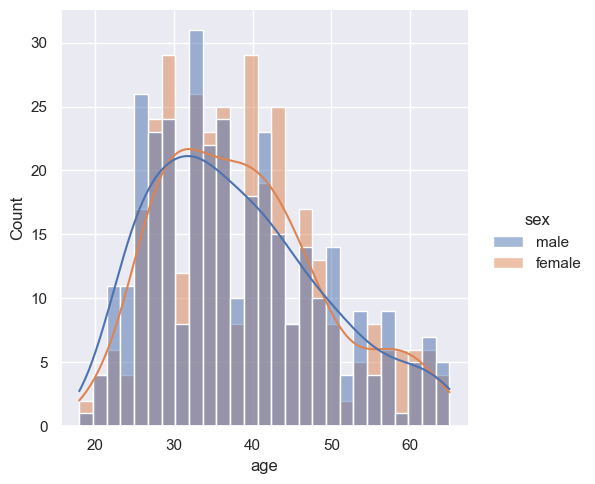

In [19]:
sns.displot(salaries_clean, x='age',  hue='sex', bins='sqrt', kde=True)

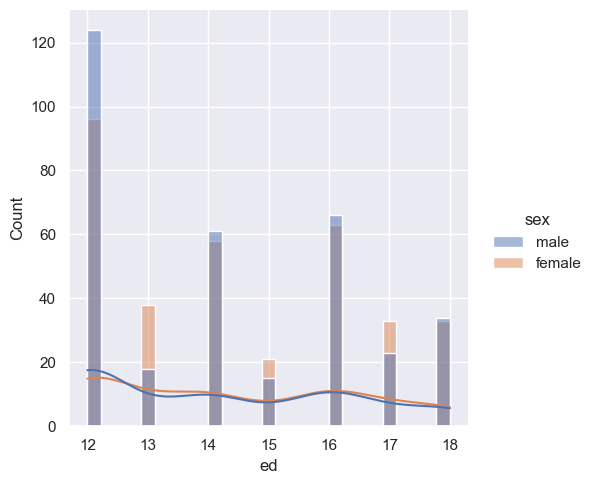

In [20]:
sns.displot(salaries_clean, x='ed',  hue='sex', bins='sqrt', kde=True)

We can observe in the distributions that:

* The number of females and males in the cleaned-up dataset is about the same.
* There are variations in the age distribution, but not a large one.
* There are few instances for the younger and older age groups. This may or may not be a problem. We will check that later.
* The education distribution is about the same, with a few exceptions.

# Analysis

We will start with an overview of the relationships among the features (columns), split by sex.

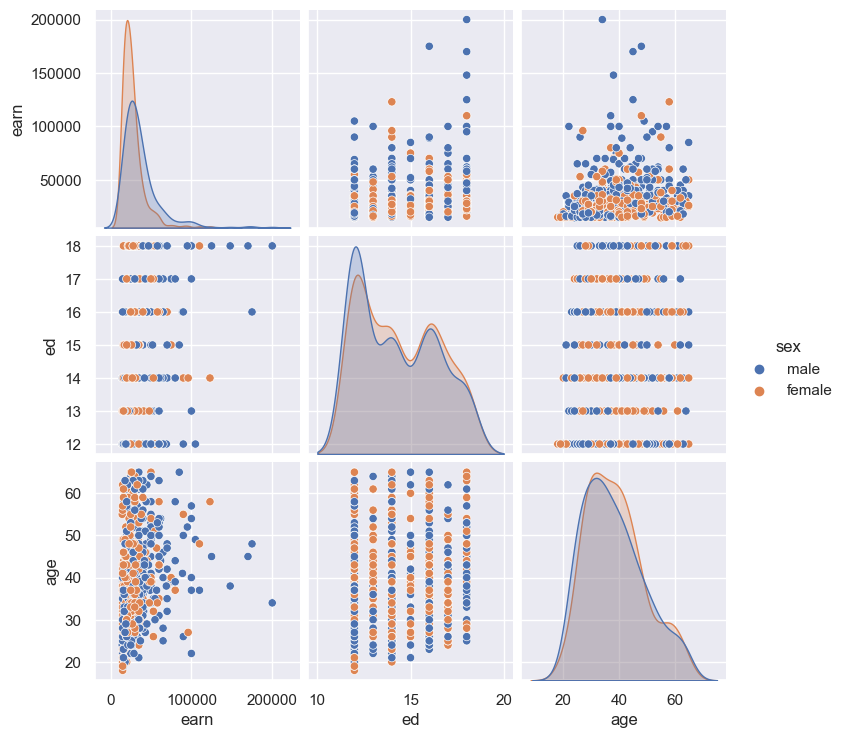

In [21]:
sns.pairplot(salaries_clean, hue='sex')

In [22]:
salaries_clean.groupby(['sex', 'race']).size().unstack()

race,black,hispanic,other,white
sex,,,,
female,36,17,8,281
male,25,19,7,290


## Analyzing experience

<AxesSubplot: xlabel='age', ylabel='earn'>

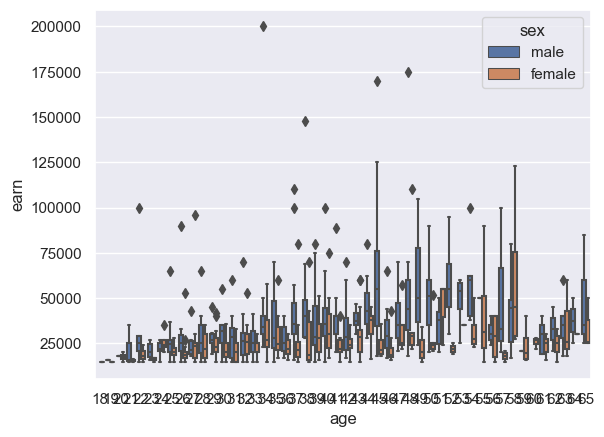

In [23]:
sns.boxplot(data=salaries_clean, x='age', y='earn', hue='sex')

This plot shows that females earn less on average. More importantly, females earn less in all quartiles and have fewer outliers in the fourth quartile (the higher end of salaries).

## Analyzing education level

<AxesSubplot: xlabel='ed', ylabel='earn'>

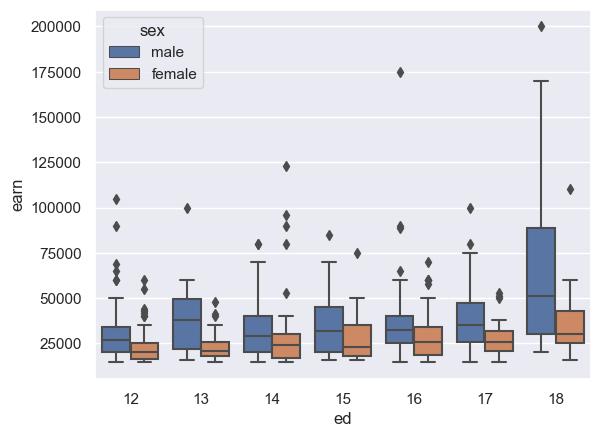

In [24]:
sns.boxplot(data=salaries_clean, x='ed', y='earn', hue='sex')

This plot also shows that females earn less than males on average, and again the quartiles are lower for females.

# Conclusions

We collected enough evidence to point to potential gender discrimination in salaries at this company:

- For the same age level, females make less on average and in general (all quartiles).
- For the same education level, females again make less on average and in general.